# Autocaptioning with Modelception

This notebook shows a quick walkthrough of the caption generation pipeline.

1. (region proposal) Run GLIP to detect relevant objects and get crops using the bounding boxes
2. (caption per region) Use BLIP2 to generate captions for each crop
3. (filtering) Get the CLIP similarities between every caption and every crop and choose the best caption for each crop
4. (filtering) Throw away the captions that do not have the highest cosine similarities with their crop
5. (summarization) Ask GPT4 to remove any outliers
6. (summarization) Ask GPT4 to generate a final caption for the entire image



The repository is self-contained. To use, follow these steps:
- In a virtual env, `pip install -r requirements.txt`
- Set the [OpenAI API key](https://platform.openai.com/account/api-keys), `export OPENAI_API_KEY=<your-key-here>`

To see the GLIP model in action, simply run
```
python glip_client.py
```

To use the CaptionGenerator outside of this notebook, simply run
```
python CaptionGenerator.py
```

In [1]:
from PIL import Image
import dotenv
import os
import matplotlib.pyplot as plt

from CaptionGenerator import CaptionGenerator

/home/dshah/anaconda3/envs/clipnav/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading caption generator


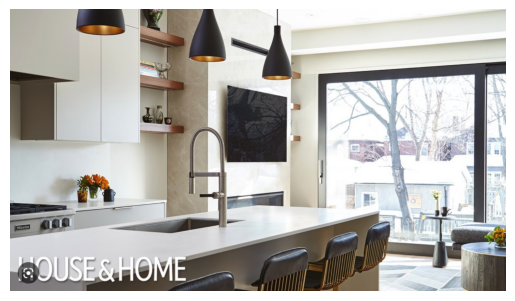

In [2]:
image = Image.open("test_images/house_kitchen.png")
if image.mode == 'RGBA':
    image = image.convert('RGB')
plt.imshow(image)
plt.axis('off')

# Load the caption generator
print("Loading caption generator")
dotenv.load_dotenv(".env", override=True)
openai_key =  os.getenv("OPENAI_API_KEY")
device = 'cuda:1'

## CaptionGenerator

The CaptionGenerator class uses a combination of GLIP, CLIP, BLIP2, and GPT-4/3.5. The relevant knobs are as follows:

- `verbose` prints all relevant entities. Recommended for debugging.
- `gpt4=True` uses the GPT-4 API. If you don't have access, set to False (uses gpt-3.5-turbo).
- `topk` refers to the number of objects used for generating the final caption. Set to `-1` for all objects, note that this may lead to very descriptive captions that refer to the smallest of entities.
- `filter` refers to the CLIP filtering pipeline, where the BLIP2 captions are "verified" using a second, independent model (CLIP). Seems to help somewhat, but slow.

The inference time on the notebook is representative of the actual inference time, but it can likely be faster when used directly in python (Jupyter notebooks can be slow).

### Base pipeline, fastest

- `filter=False`
- `topk=5`

_Typical inference time: 8 seconds_

In [3]:
cg = CaptionGenerator(openai_key, device, verbose=False, filter=False, topk=5, gpt4=True)

In [4]:
# Generate a caption
caption = cg.caption_image(image)
print(caption)

A kitchen with white cabinets and countertops, black pendant light, chairs, and a large window, featuring a black and white picture hanging on the wall.


### No topk pipeline, slower

- `filter=False`
- `topk=-1`

_Typical inference time: 10 seconds_

In [5]:
cg_better = CaptionGenerator(openai_key, device, verbose=False, filter=False, topk=-1, gpt4=True)

In [6]:
# Generate a caption
caption = cg_better.caption_image(image)
print(caption)

A well-lit kitchen and living room with white countertops, chairs, and cabinets, featuring a large window, wooden table with a vase of flowers, and a black pendant light.


### Best pipeline, slowest

- `filter=True`
- `topk=-1`

_Typical inference time: 32 seconds_

In [7]:
cg_best = CaptionGenerator(openai_key, device, verbose=False, filter=True, topk=-1, gpt4=True)

In [8]:
# Generate a caption
caption = cg_best.caption_image(image)
print(caption)

A kitchen and living room with a large window, featuring a white countertop with a sink and faucet, a stove top oven, white cabinets, a black pendant light, a black chair next to a white table, and a wooden table with a vase and orange flowers.
